In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [142]:
def outside_of_range(x, range):
  for i, val in enumerate(x):
    if val < range[i,0] or val > range[i,1]: # if less than min or greater than max
      return True
  return False

def new_pos_with_priors(x, sigmas, priors):
  new_pos = np.zeros(np.shape(x))
  for i, pos in enumerate(x):
    xnp1 = np.array([np.random.normal(loc, sigma) for loc, sigma in zip(pos, sigmas)])
    while outside_of_range(xnp1, priors):
      xnp1 = np.array([np.random.normal(loc, sigma) for loc, sigma in zip(pos, sigmas)])
    new_pos[i] = xnp1
  return np.array(new_pos)

def MCMC_swapper(X_0, sigmas, nmax, model, betas, priors, ns = 30):
  print("Swapping MCMC starting with initial guess: {} at Betas: {}".format(X_0, betas))
  n_betas = len(betas)
  
  when_swap = np.random.random(nmax) < 1/ns # choose all swapping break times
  which_swap = np.random.randint(0, n_betas-1, sum(when_swap)) # B_i to swap

  X_acc = np.zeros((n_betas, nmax, len(X_0))) # global position array
  L_acc = np.zeros((n_betas, nmax)) # global probability array
  N_acc = np.zeros(n_betas) # global number accepted
  acc_rat = np.zeros((n_betas, nmax)) # global acceptance ratios

  # cvar = sigmas**2*np.identity(len(X_0)) #Covariance matrix diagonalized sigmas

  Xn = [X_0 for _ in range(n_betas)] # current position array
  Ln = np.array([model(*x) for x in Xn]) # current probability array
  log_U1 = np.log(np.random.random((nmax, n_betas))) # Log random proposal value
  log_U2 = np.log(np.random.random(sum(when_swap))) # swap proposal values
  n_swaps = 0
  swaps_acc = 0

  for i in tqdm.tqdm(range(nmax)):
    Xnp1 = new_pos_with_priors(Xn, sigmas, priors) # generate array of of new pos
    Lnp1 = [model(*x) for x in Xnp1] # compute probability at each new position
    log_r = (Lnp1 - Ln)*betas # Log probability ratio with Betas
    condition = log_U1[i] <= log_r # find which values have passed the proposal
    Ln = np.where(condition, Lnp1, Ln) # update the appropriate positions
    N_acc = np.where(condition, N_acc + 1, N_acc) # update N_acc
    condition = (condition*np.ones(np.shape(Xnp1.T))).T # reshape condition arr
    Xn = np.where(condition, Xnp1, Xn) # update locations
    # swapping time
    if when_swap[i]:
      j = which_swap[n_swaps]
      log_r = (betas[j+1] - betas[j])*(Ln[j] - Ln[j+1])
      if log_U2[n_swaps] < log_r:
        Ln[j], Ln[j+1] = Ln[j+1], Ln[j]
        cxjp1 = Xn[j+1].copy()
        cxj = Xn[j].copy()
        Xn[j] = cxjp1
        Xn[j+1] = cxj
        swaps_acc += 1
      n_swaps +=1
    X_acc[:,i,:] = Xn # log results to global arrays
    L_acc[:,i] = Ln # log results to global arrays
    acc_rat[:,i] = N_acc/(i+1) # log results to global arrays

  print("\nMCMC completed")
  return X_acc, L_acc, acc_rat, n_swaps, swaps_acc

In [7]:
def density(mass, radius):
  volume = 4/3*np.pi*radius**3
  if isinstance(radius, (int, float)):
    return mass/volume if radius > 0 else np.inf
  else:
    return np.where(radius>0., mass/volume, np.inf)

def mass(density, radius):
  volume = 4/3*np.pi*radius**3
  if isinstance(radius, (int, float)):
    return density*volume if radius > 0 else np.inf
  else:
    return np.where(radius>0., density*volume, 0)

def radius(mass, density):
  volume = mass/density
  return (3/4/np.pi*volume)**(1/3)

def generalized_chi2(predictions, observations, sigmas):
  return np.sum((np.power(np.subtract(np.transpose(predictions), observations), 2)/np.power(sigmas, 2)).T, axis=0)

def pfm_small_mass_c2019(big_mass, mass_rat, big_radius, small_radius, angle, v_scale):
  conf = collresolve.Conf()
  collresolve.conf_unit_si(conf)
  collresolve.conf_model(conf, collresolve.MODEL_C2019)
  big = collresolve.Body(mass=big_mass, radius=big_radius)
  small = collresolve.Body(mass=mass_rat*big_mass, radius=small_radius)
  velocity = v_scale*collresolve.escape_velocity(conf, big, small)
  collresolve.setup(conf, big, small, velocity, angle)
  res, regime = collresolve.resolve( conf, big, small, 2, 1 )
  big, small, debris = res
  predictions = [small.mass]

  observations = [psyche_obs['mass']]
  sigmas = [psyche_obs_err['mass']]
  const = np.log(1/(2*np.pi)**(len(sigmas)/2)*1/np.prod(sigmas))

  chi2 = generalized_chi2(predictions, observations, sigmas)

  return const - chi2/2

def print_result_density(big_density, small_density, big_radius, small_radius, angle, v_scale):
  conf = collresolve.Conf()
  collresolve.conf_unit_si(conf)
  collresolve.conf_model(conf, collresolve.MODEL_C2019)
  big = collresolve.Body(mass=mass(big_density, big_radius), radius=big_radius)
  small = collresolve.Body(mass=mass(small_density, small_radius), radius=small_radius)
  # print('big:', big)
  # print('small:', small)
  velocity = v_scale*collresolve.escape_velocity(conf, big, small)
  collresolve.setup(conf, big, small, velocity, angle)
  res, regime = collresolve.resolve( conf, big, small, 2, 1 )
  print( "impact velocity = {0:.5f} m/s".format( collresolve.impact_velocity( conf, big, small ) ) )
  print( "velocity ratio = {0:.2f}".format( collresolve.impact_velocity( conf, big, small ) / collresolve.escape_velocity( conf, big, small ) ) )
  print( "impact angle = {0:.1f} deg".format( np.degrees( collresolve.impact_angle( conf, big, small ) ) ) )
  print( "  regime =", collresolve.regime_desc( regime ) )
  # print('big:', res[0])
  print('psyche: density - {:.3f}, diameter - {:.2f} km'.format(density(res[1].mass, res[1].radius), 2*res[1].radius*1e-3))

def print_result_mass(big_mass, mass_rat, big_radius, small_radius, angle, v_scale):
  conf = collresolve.Conf()
  collresolve.conf_unit_si(conf)
  collresolve.conf_model(conf, collresolve.MODEL_C2019)
  big = collresolve.Body(mass=big_mass, radius=big_radius)
  small = collresolve.Body(mass=big_mass*mass_rat, radius=small_radius)
  velocity = v_scale*collresolve.escape_velocity(conf, big, small)
  collresolve.setup(conf, big, small, velocity, angle)
  res, regime = collresolve.resolve( conf, big, small, 2, 1 )
  print( "impact velocity = {0:.5f} m/s".format( collresolve.impact_velocity( conf, big, small ) ) )
  print( "velocity ratio = {0:.2f}".format( collresolve.impact_velocity( conf, big, small ) / collresolve.escape_velocity( conf, big, small ) ) )
  print( "impact angle = {0:.1f} deg".format( np.degrees( collresolve.impact_angle( conf, big, small ) ) ) )
  print( "  regime =", collresolve.regime_desc( regime ) )
  # print('big:', res[0])
  print('psyche: mass - {:.3e}, diameter - {:.2f} km'.format(res[1].mass, 2*res[1].radius*1e-3))

In [484]:
predictions = [2.3e19]

observations = [psyche_obs['mass']]
sigmas = [psyche_obs_err['mass']]
const = np.log(1/(2*np.pi)**(len(sigmas)/2)*1/np.prod(sigmas))

chi2 = generalized_chi2(predictions, observations, sigmas)

const, chi2/2

(-42.00879526315876, 0.017244897959183672)

In [513]:
psyche_obs = {'density':3780, 'diameter':222e3, 'mass':2.287e19}
psyche_obs_err = {'density':340, 'diameter':4e3, 'mass':0.07e19}
psyche_obs_units = {'density':'kg/m3', 'diameter':'m', 'mass':'kg'}

priors = np.array([
    # [2000, 6000], # Big Densities (kg/m3)
    # [2000, 6000], # Small Densities (kg/m3)
    [1e-3*M_earth, M_earth], # Big Mass (kg)
    [0.01, 0.7], # Small Mass ratio
    [500e3, 10000e3], # Big Radii (m)
    [50e3, 1000e3], # Small Radii (m)
    [0, np.pi/2], # angle (radians)
    [1, 4] # impact velocity (Vesc)
])
# sigma = [50, 50, 100e3, 10e3, np.radians(10), 1] # rho1, rho2, r1, r2, theta, vesc
sigma = [1e-4*M_earth, 0.03, 300e3, 50e3, np.radians(10), 0.5] # m1, m2, r1, r2, theta, vesc

# Initial_guesses = [5.5e+03, 3.5e+03, 0.7e6, 1e5, np.pi/4, 3.]
Initial_guesses = [1.1e-3*M_earth, 0.02, 0.7e6, 1e5, np.pi/3, 4.]

nmax = 1000000
betas = np.array([0.01, 0.208, 0.406, 0.604, 0.802, 1])
# betas = np.array([0.8, 1])
n_betas = len(betas)

In [514]:
m_psyche = 3780*4/3*np.pi*111e3**3
print(m_psyche, '+/-', m_psyche*np.sqrt((340/3780)**2 + (3*4e3/222e3)**2))

2.165455909220518e+19 +/- 2.2724207797815176e+18


In [515]:
X_acc, L_acc, acc_rat, n_swaps, swaps_acc = MCMC_swapper(Initial_guesses, sigma, nmax, pfm_small_mass_c2019, betas, priors)

Swapping MCMC starting with initial guess: [6.5692e+21, 0.02, 700000.0, 100000.0, 1.0471975511965976, 4.0] at Betas: [0.01  0.208 0.406 0.604 0.802 1.   ]


100%|██████████| 1000000/1000000 [08:17<00:00, 2010.84it/s]


MCMC completed


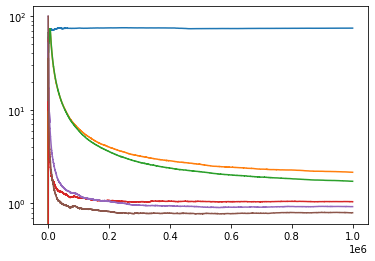

In [520]:
plt.semilogy(acc_rat[:, :].T*100)

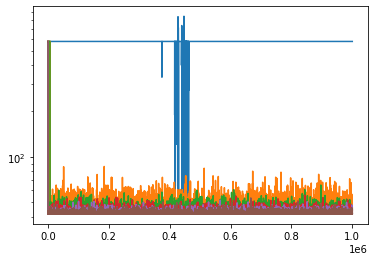

In [517]:
plt.semilogy(-L_acc.T)

In [518]:
print('Target Mass: {:.2e}\nImpactor Mass Ratio: {:.3f}\nTarget Radius: {:.2e}\nImpactor Radius: {:.2e}'.format(*X_acc[-1, np.argmax(L_acc[-1]), :4]))
print_result_mass(*X_acc[-1, np.argmax(L_acc[-1]), :])

Target Mass: 7.41e+21
Impactor Mass Ratio: 0.012
Target Radius: 8.27e+06
Impactor Radius: 5.97e+05
impact velocity = 884.40609 m/s
velocity ratio = 2.63
impact angle = 39.0 deg
  regime = Hit and run
psyche: mass - 2.287e+19, diameter - 241.48 km


In [521]:
burn_ins = []
for i in range(n_betas):
  burn_in = 0
  med_val = np.median(L_acc[i])
  while L_acc[i, burn_in] < med_val:
    burn_in +=1
  burn_ins.append(burn_in)

In [569]:
print('Target Mass: {:.3f}'.format(7.41e21/M_earth*1e3))

Target Mass: 1.241


Text(0.5, 1.0, 'Impact Velocity')

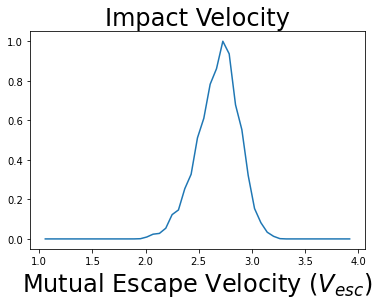

In [565]:
i=5
# bins = np.logspace(np.log10(min(X_acc[-1, :, i])), np.log10(max(X_acc[-1, :, i])), 30)
bins = np.linspace(min(X_acc[-1, :, i]), max(X_acc[-1, :, i]), 50)
values, bins = np.histogram(X_acc[-1, burn_ins[-1]:, i], bins = bins, density=True)
points = np.array([(bins[j] + bins[j+1])/2 for j in range(len(bins)-1)])
plt.plot(points, values/max(values))
plt.xlabel('Mutual Escape Velocity ($V_{esc}$)', fontsize = 24)
plt.title("Impact Velocity", fontsize = 24)


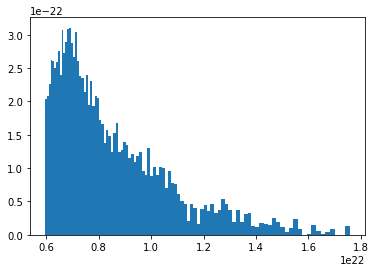

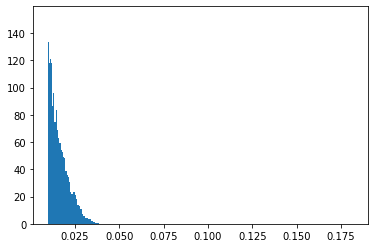

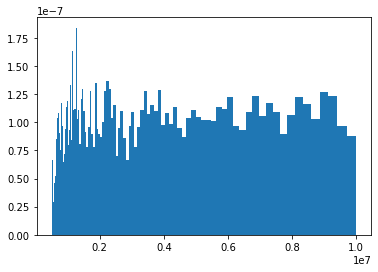

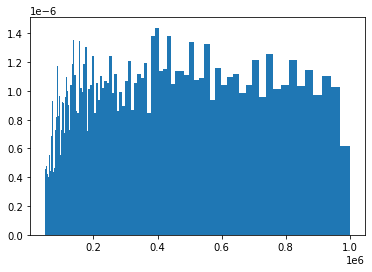

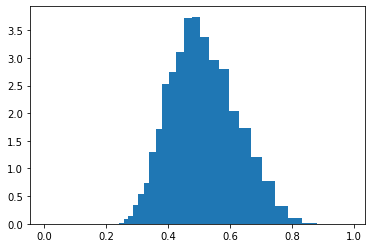

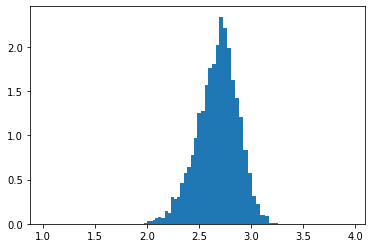

In [519]:
for i in range(6):
    plt.figure()
    # plt.scatter(range(nmax), X_acc[-1, :, i], 10); plt.show()
    # for j in range(6):
    #     plt.hist(X_acc[j, :, i], 25, alpha = .3)
    bins = np.logspace(np.log10(min(X_acc[-1, :, i])), np.log10(max(X_acc[-1, :, i])), 100)
    plt.hist(X_acc[-1, :, i], bins=bins, alpha = 1, density=True)
    plt.show()

In [409]:
for i in range(6):
    values, bins = np.histogram(X_acc[-1, :, i], 25)
    points = ([np.mean(bins[k:k+2]) for k in range(len(bins)-1)])
    print(points[np.argmax(values)])

5439.889428080096
3679.996133752986
690007.8142934977
102629.11370824829
1.3543204629279004
3.3090536290631047


In [422]:
values, bins = np.histogram(X_acc[-1, :, 0], 25)
points = np.array([np.mean(bins[k:k+2]) for k in range(len(bins)-1)])
X_acc[-1, np.argmax(np.where(points>0, values, 0)), : ]

array([5.50521460e+03, 3.62767317e+03, 4.35259652e+06, 3.40880927e+05,
       3.58017973e-01, 3.31169089e+00])

In [416]:
print_result(*[5439.889428080096, 3679.996133752986, 690007.8142934977, 102629.11370824829, 1.3543204629279004, 3.3090536290631047])

big: collresolve.Body(mass=7.485842904823395e+21, radius=690007.8142934977, pos_x=0.0, pos_y=0.0, pos_z=0.0, vel_x=0.0, vel_y=0.0, vel_z=0.0)
small: collresolve.Body(mass=1.6662789461373565e+19, radius=102629.11370824829, pos_x=0.0, pos_y=0.0, pos_z=0.0, vel_x=0.0, vel_y=0.0, vel_z=0.0)
impact velocity = 3719.46540 m/s
velocity ratio = 3.31
impact angle = 77.6 deg
  regime = Hit and run
psyche: density - 3101.700, diameter - 208.43 km


# Collresolve test

In [442]:
conf = collresolve.Conf()
collresolve.conf_unit_m_earth(conf)
collresolve.conf_model(conf, collresolve.MODEL_C2019)
vel = 20.e3
angle = np.radians(45.)
big = collresolve.Body( mass = 1., radius = 6.371e6 )
small = collresolve.Body( mass = 0.0, radius = 3.4e6 )
collresolve.setup( conf, big, small, vel, angle )
print( "impact velocity = {0:.1f} m/s".format( collresolve.impact_velocity( conf, big, small ) ) )
print( "velocity ratio = {0:.2f}".format( collresolve.impact_velocity( conf, big, small ) / collresolve.escape_velocity( conf, big, small ) ) )
print( "impact angle = {0:.1f} deg".format( np.degrees( collresolve.impact_angle( conf, big, small ) ) ) )
res, regime = collresolve.resolve( conf, big, small, 2, 1 )
print(big.mass, big.radius, density(big.mass*5.972e24, big.radius))
print(small.mass, small.radius, density(small.mass*5.972e24, small.radius))
for body in res:
    print(body.mass, body.radius, density(body.mass*5.972e24, body.radius))

impact velocity = nan m/s
velocity ratio = nan
impact angle = nan deg
1.0 6371000.0 5513.258738589093
0.0 3400000.0 0.0
nan nan inf
0.0 0.0 inf
nan 0.0 inf


In [452]:
3*M_earth/4/np.pi/1e8**3

1.4257099802171986